In [1]:
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
from load_dataset import load_data

1 Physical GPUs, 1 Logical GPUs


In [3]:
# No info messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [4]:
# Limit GPU memory growth for RTX cards
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Enable FP16 on RTX cards for faster processing
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from tensorflow.keras import datasets, layers, models

Our dataset directory should contain 2 folders inside of it: *bad* and *healthy*. Those 2 are going to be our final classes, stored under `CLASS_NAMES`.

In [6]:
data_dir = os.path.join("dataset")
data_dir = pathlib.Path(data_dir)

list_ds = tf.data.Dataset.list_files(str(data_dir / "*/*"))

image_count = len(list(data_dir.glob("*/*.jpg")))

CLASS_NAMES = np.array([item.name for item in data_dir.glob("*")])
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [7]:
ds = load_data()

Splits our dataset into training data and testing data with a ratio of 80/20 set through `test_size`. Also fixed our random seed through `random_state` in order to provide reproducibility in later runs.

In [8]:
from sklearn.model_selection import train_test_split
ds_train, ds_test = train_test_split(np.array(list(ds.as_numpy_iterator())) ,test_size=0.2, random_state=42)

Splits our labels and data into 2 different arrays

In [9]:
train_data = ds_train[:,0]
train_label = ds_train[:,1]
test_data = ds_test[:,0]
test_label = ds_test[:,1]

Lots of reshapes into our arrays

In [10]:
for i in range(len(train_data)):
    train_data[i] = train_data[i].reshape(-1, 256, 256, 3).astype(np.float16) 
for i in range(len(test_data)):
    test_data[i] = test_data[i].reshape(-1, 256, 256, 3).astype(np.float16) 

In [11]:
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)

In [12]:
for i in range(len(train_label)):
    train_label[i] = int(train_label[i][1])
for i in range(len(test_label)):
    test_label[i] = int(test_label[i][1])

Let's see if everything worked out as we wanted by plotting some of our data

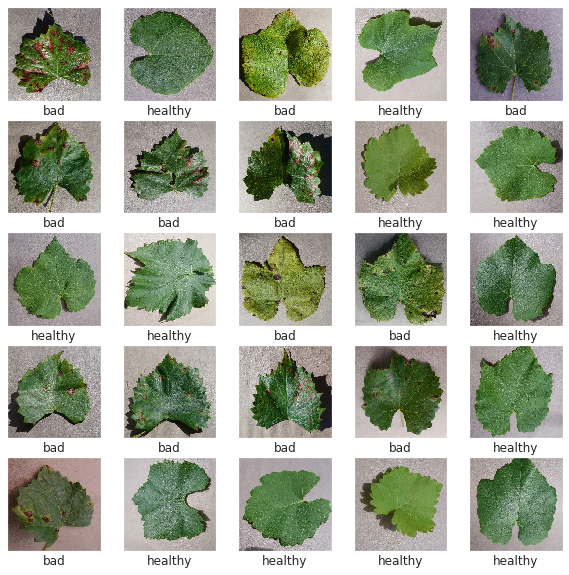

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i].astype(np.float32), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(CLASS_NAMES[train_label[i]])
plt.show()

In [14]:
train_label = tf.convert_to_tensor(train_label, dtype=tf.int8)
test_label = tf.convert_to_tensor(test_label, dtype=tf.int8)

This model is based on ResNet, which can be seen [here](https://www.researchgate.net/figure/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_fig3_331364877). We will modify its input layer and add a classifier at its end to suit our needs.

In [15]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
model = models.Sequential()

ResNet = ResNet50V2(include_top=False, input_shape=(256,256,3))

# Freeze all of the 190 layers of resnet
for layer in ResNet.layers:
    layer.trainable = False
model.add(ResNet)    
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 23,695,873
Trainable params: 131,073
Non-trainable params: 23,564,800
_________________________________________________________________


In [19]:
import resource
import gc
class MemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        gc.collect()
        print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

import time
start = time.time()

history = model.fit(train_data, train_label, epochs=100, batch_size=64,
                    validation_data=(test_data, test_label), callbacks=[MemoryCallback()])
end = time.time() - start

print("Took ", end, "s")

Epoch 1/100
88/88 [==============================] - 16s 185ms/step - loss: 0.1112 - accuracy: 0.9544 - val_loss: 0.0055 - val_accuracy: 0.9986
Epoch 2/100
88/88 [==============================] - 14s 155ms/step - loss: 0.0136 - accuracy: 0.9957 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/100
88/88 [==============================] - 14s 157ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/100
88/88 [==============================] - 14s 155ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/100
88/88 [==============================] - 14s 157ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/100
88/88 [==============================] - 14s 157ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/100
88/88 [==============================] - 14s 158ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 9.2177e-04 - val_accur

88/88 [==============================] - 14s 161ms/step - loss: 5.6805e-05 - accuracy: 1.0000 - val_loss: 3.5382e-04 - val_accuracy: 1.0000
Epoch 35/100
88/88 [==============================] - 14s 160ms/step - loss: 6.6114e-05 - accuracy: 1.0000 - val_loss: 2.6077e-04 - val_accuracy: 1.0000
Epoch 36/100
88/88 [==============================] - 14s 160ms/step - loss: 5.1909e-05 - accuracy: 1.0000 - val_loss: 1.8326e-04 - val_accuracy: 1.0000
Epoch 37/100
88/88 [==============================] - 14s 161ms/step - loss: 4.4384e-05 - accuracy: 1.0000 - val_loss: 2.5713e-04 - val_accuracy: 1.0000
Epoch 38/100
88/88 [==============================] - 14s 157ms/step - loss: 5.7920e-05 - accuracy: 1.0000 - val_loss: 1.9739e-04 - val_accuracy: 1.0000
Epoch 39/100
88/88 [==============================] - 14s 160ms/step - loss: 3.9788e-05 - accuracy: 1.0000 - val_loss: 1.9897e-04 - val_accuracy: 1.0000
Epoch 40/100
88/88 [==============================] - 14s 159ms/step - loss: 5.1670e-05 - accur

88/88 [==============================] - 14s 157ms/step - loss: 1.0923e-05 - accuracy: 1.0000 - val_loss: 1.1221e-04 - val_accuracy: 1.0000
Epoch 68/100
88/88 [==============================] - 14s 158ms/step - loss: 9.9567e-06 - accuracy: 1.0000 - val_loss: 9.2672e-05 - val_accuracy: 1.0000
Epoch 69/100
88/88 [==============================] - 14s 158ms/step - loss: 2.2704e-05 - accuracy: 1.0000 - val_loss: 7.1293e-05 - val_accuracy: 1.0000
Epoch 70/100
88/88 [==============================] - 14s 158ms/step - loss: 1.1181e-05 - accuracy: 1.0000 - val_loss: 7.1672e-05 - val_accuracy: 1.0000
Epoch 71/100
88/88 [==============================] - 14s 156ms/step - loss: 8.5912e-06 - accuracy: 1.0000 - val_loss: 8.1089e-05 - val_accuracy: 1.0000
Epoch 72/100
88/88 [==============================] - 14s 159ms/step - loss: 8.6528e-06 - accuracy: 1.0000 - val_loss: 8.6156e-05 - val_accuracy: 1.0000
Epoch 73/100
88/88 [==============================] - 14s 158ms/step - loss: 8.0161e-06 - accur

In [ ]:
plt.close()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)
print(test_acc)

In [ ]:
model.save('model_resnet.h5')